In [1]:
#importing packages
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import fiona
from fiona import Feature, Geometry
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling

In [7]:
def band_stack(top_path, raster_filename):
    p = Path(top_path)
    band_files = sorted(list(p.glob('*.tif')))
    print(band_files)
    #by default the band order is G, group1, NIR, RE, R
    #as files were created in that order by Pix4D
    #We are swapping NIR and R bands and dropping group1,
    #so the order is now G, R, RE, NIR for our stack
    del band_files[1]
    band_files[1], band_files[3] = band_files[3], band_files[1]
    with rio.open(band_files[0]) as src0:
        meta = src0.meta
    # Update metadata to reflect the number of layers
    meta.update(count = len(band_files))
    # Read each layer and write it to stack
    with rio.open(Path(top_path, raster_filename), 'w', **meta) as dst:
        for id, layer in enumerate(band_files, start=1):
            with rio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [2]:
#stacking Green, Red, Red Edge, and Near Infrared band individual rasters
#into one multi-band raster
#top_path='/gdrive/My Drive/Fynbos/October_2023/Grootbos_Drone_fil/s/mavic3m/'
#S:\mc5545\SA_Drone_data\burn2022_hr\reflectance
top_path='S:/mc5545/SA_Drone_data'
raster_path = top_path+'burn2022_hr/reflectance'
raster_filename = 'burn2022_hr_band_stack.tif'
#band_stack(raster_path,raster_filename)

In [3]:
raster_path

'S:/mc5545/SA_Drone_databurn2022_hr/reflectance'

In [4]:
#load raster
raster = rxr.open_rasterio(Path(raster_path, raster_filename),masked=True).squeeze()
rgb = rxr.open_rasterio(Path(raster_path,'burn2022_highres_transparent_reflectance_group1.tif'))
#load shapefile
shp = gpd.read_file(Path(top_path,'burn2022_hr/shapefiles/test.shp'))
geometries = shp.geometry.apply(mapping)

#test clip of first plot "p1"
i = 0
p1 = raster.rio.clip([geometries[i]],shp.crs)
p1_np = np.asarray(p1)
p1_rgb = rgb.rio.clip([geometries[i]],shp.crs)
p1_rgb_np = np.asarray(p1_rgb)

RasterioIOError: S:/mc5545/SA_Drone_databurn2022_hr/reflectance/burn2022_hr_band_stack.tif: No such file or directory

In [16]:
raster

<xarray.DataArray (band: 4, y: 8569, x: 8730)>
[299229480 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 3.544e+05 3.544e+05 ... 3.544e+05 3.544e+05
  * y            (y) float64 6.177e+06 6.177e+06 ... 6.177e+06 6.177e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [15]:
p1_np.shape

(4, 553, 552)

In [ ]:
geometries

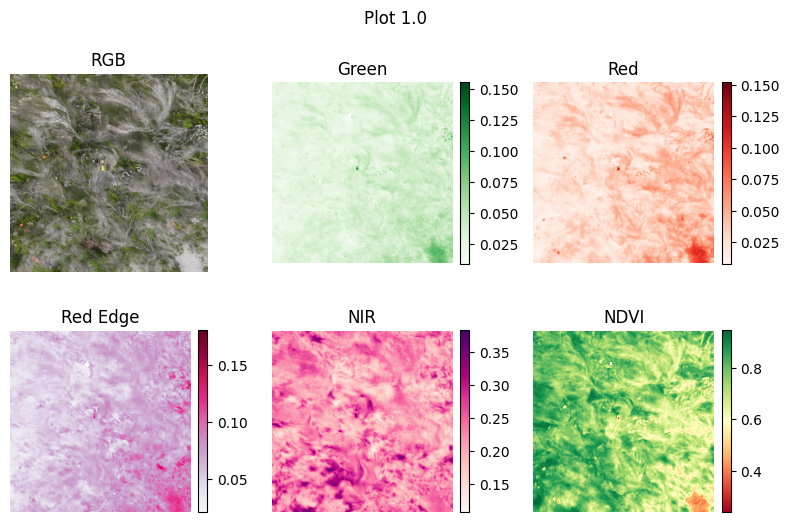

In [8]:
ndvi = (p1_np[3]-p1_np[1])/(p1_np[3]+p1_np[1])
p1_disp = p1_rgb/p1_rgb.max()
rgb_disp = np.dstack((p1_disp[0],p1_disp[1],p1_disp[2]))

plt.figure(figsize=(8,8))
plt.subplot(3,3,1)
plt.imshow(rgb_disp),plt.axis('off'),plt.title('RGB')
plt.subplot(3,3,2)
plt.imshow(p1_np[0],cmap='Greens'),plt.axis('off'),plt.title('Green'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,3,3)
plt.imshow(p1_np[1],cmap='Reds'),plt.axis('off'),plt.title('Red'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,3,4)
plt.imshow(p1_np[2],cmap='PuRd'),plt.axis('off'),plt.title('Red Edge'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,3,5)
plt.imshow(p1_np[3],cmap='RdPu'),plt.axis('off'),plt.title('NIR'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,3,6)
plt.imshow(ndvi,cmap='RdYlGn'),plt.axis('off'),plt.title('NDVI'),plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(shp['id'][i]))
plt.tight_layout()
plt.show()

In [ ]:
len(shp)

100

In [ ]:
#clipped plot for first 10
# Create an empty list to store the clipped rasters
clipped_rasters = []

#for i in range(len(shp)):
for i in range(10):
  # Clip the raster with the current geometry
  p1 = raster.rio.clip([geometries[i]],shp.crs)

  # Convert the clipped raster to a NumPy array
  p1_np = np.asarray(p1)

  # Append the clipped raster array to the list
  clipped_rasters.append(p1_np)


In [ ]:
clipped_rasters

Normalized Difference Vegetation Index (NDVI)

Formula: NDVI = (NIR – RED) / (NIR + RED)

In [ ]:
# Assuming you have already created the `clipped_rasters` list as shown in the previous response.

# Create an empty list to store the NDVI values for each clipped raster
ndvi_values = []

# Iterate through the clipped rasters
for p1_np in clipped_rasters:
    # Calculate NDVI using the formula
    ndvi = (p1_np[3] - p1_np[1]) / (p1_np[3] + p1_np[1])
    #ndvi_mean=np.mean(ndvi)
    # Append the NDVI value to the list
    ndvi_values.append(ndvi)

# Now, the `ndvi_values` list contains the NDVI values for all the clipped rasters.


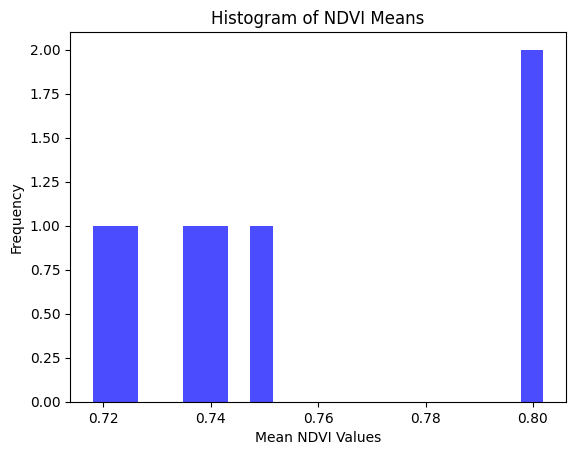

In [ ]:

# Calculate the means of each NDVI array
means = [np.mean(ndvi) for ndvi in ndvi_values]

# Create a histogram of the means
plt.hist(means, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of NDVI Means')
plt.xlabel('Mean NDVI Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


In [ ]:
means

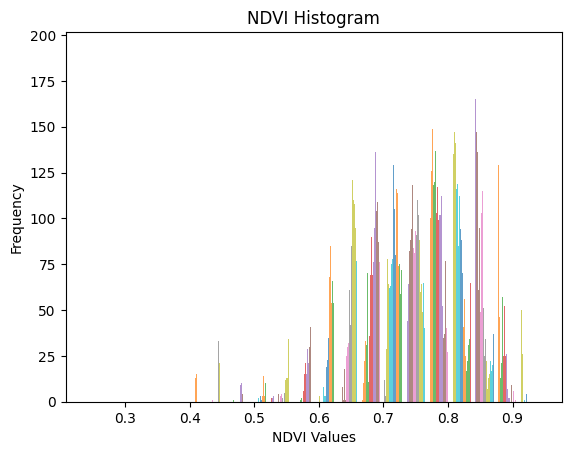

In [ ]:
import matplotlib.pyplot as plt
i=0
# Create a histogram of the NDVI values
plt.hist(ndvi_values[i], bins=20, alpha=0.7)
plt.title('NDVI Histogram')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


https://eos.com/blog/vegetation-indices/

https://support.micasense.com/hc/en-us/articles/227837307-Overview-of-Agricultural-Indices




**Red-Edge Chlorophyll Vegetation Index (RECl)**

**Formula:** RECI = (NIR / Red Edge) – 1

**Normalized Difference Red Edge Vegetation Index (NDRE)**

**Formula:** NDRE = (NIR – RED EDGE) / (NIR + RED EDGE)

**Key fact:** The given vegetation index applies for high-density canopy cover.

**When to use:** NDRE is typically used to monitor crops that have reached the maturity stage.

**Green Normalized Difference Vegetation Index (GNDVI)**

**Formula:** GNDVI = (NIR – GREEN) / (NIR + GREEN)

**Key fact:** GNDVI measures chlorophyll content more accurately than NDVI.

**Optimized Soil Adjusted Vegetation Index (OSAVI)**
Formula: OSAVI = (NIR – RED) / (NIR + RED + 0.16)

**Key fact:** The adjustment allows greater soil variation in OSAVI compared to SAVI when canopy cover is low. OSAVI has a better sensitivity to canopy cover exceeding 50%.

**Where to use:** to monitor areas with low-density vegetation with bare soil areas through the canopy.

**Green Chlorophyll Vegetation Index (GCI)**
In remote sensing, the GCI vegetation index is used to estimate the content of leaf chlorophyll in various species of plants. The chlorophyll content reflects the physiological state of vegetation; it decreases in stressed plants and can therefore be used as a measurement of vegetation health.

**Formula:** GCI = (NIR / GREEN) – 1

**Key fact:** Better prediction of chlorophyll amount with the GCI vegetation index can be achieved by using satellite sensors that have broad NIR and green wavelengths.

**When to use:** to monitor the impact of seasonality, environmental stresses, or applied pesticides on vegetation health.

**Simple Ratio (SR)**
This is the simplest VI which is a ratio between the reflectance recorded in the Near Infra-Red (NIR) and Red bands. This is a quick way to distinguish green leaves from other objects in the scene and estimate the relative biomass present in the image. Also, this value may be very useful in distinguishing stressed vegetation from non-stressed areas.

https://www.hiphen-plant.com/vegetation-index/3582/#:~:text=Simple%20Ratio%20(SR),biomass%20present%20in%20the%20image.

Simple Ratio = ρNIR / ρRed = ρ850 / ρ675

MSR aims at alleviating the saturation drawback of NDVI. It aims to linearize the relationships between the index and biophysical parameters.
MSR = ((ρNIR/ρred) - 1)/((ρNIR/ρred)^1/2 + 1)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3859895/

RDVI: Renormalized difference vegetation index

RDVI = (ρNIR - ρred)/(ρNIR + ρred)1/2	It aims to linearize the relationships between the index and biophysical parameters.


https://www.auravant.com/en/articles/precision-agriculture/vegetation-indices-and-their-interpretation-ndvi-gndvi-msavi2-ndre-and-ndwi/

In [ ]:
# Assuming you have already created the `clipped_rasters` list as shown in the previous response.
 #so the order is now G=0, R=1, RE=2, NIR=3 for our stack
# Create an empty list to store the NDVI values for each clipped raster
ReCI_values = []
NDRE_values = []
GNDVI_values =[]
OSAVI_values= []
GCI_values  = []
SR_values   = []
MSR_values  = []
RDVI_values=  []

# Iterate through the clipped rasters
for p1_np in clipped_rasters:
    # Calculate NDVI using the formula
    ReCI = (p1_np[3] / p1_np[2])-1
    NDRE=  (p1_np[3]-p1_np[2])/(p1_np[3]+p1_np[2])
    GNDVI= (p1_np[3]-p1_np[0])/(p1_np[3]+p1_np[0])
    OSAVI= (p1_np[3]-p1_np[1])/(p1_np[3]+p1_np[1]+0.16)
    GCI=   (p1_np[3]/p1_np[0])-1
    SR=    (p1_np[3] / p1_np[1])
    MSR =  ((p1_np[3] / p1_np[1])-1)/(np.sqrt((p1_np[3] / p1_np[1])+1))
    RDVI=  np.sqrt((p1_np[3]-p1_np[1])/(p1_np[3]+p1_np[1]))

    # Append the NDVI value to the list
    ReCI_values.append(ReCI)
    NDRE_values.append(NDRE)
    GNDVI_values.append(GNDVI)
    OSAVI_values.append(OSAVI)
    GCI_values.append(GCI)
    SR_values.append(SR)
    MSR_values.apend (MSR)
    RDVI_values.append(RDVI)
# Now, the `ndvi_values` list contains the NDVI values for all the clipped rasters.



In [ ]:
SR_values

In [ ]:
GCI_values

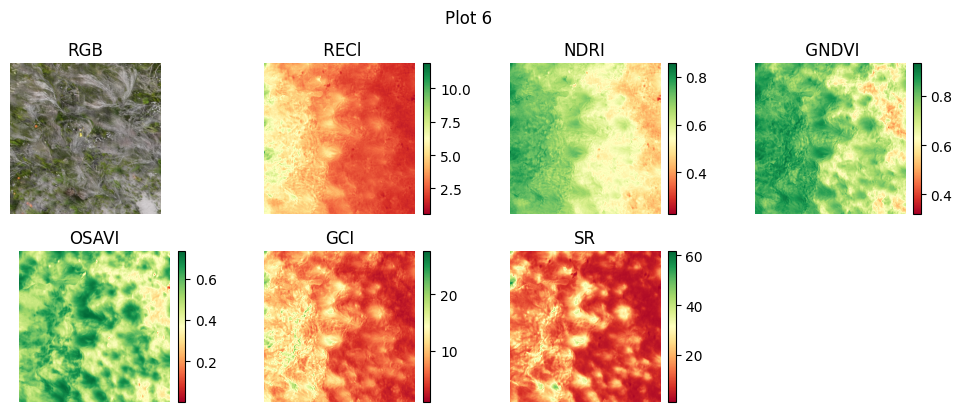

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(4,4,1)
plt.imshow(rgb_disp),plt.axis('off'),plt.title('RGB')
plt.subplot(4,4,2)
plt.imshow(ReCI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title(' RECl'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(4,4,3)
plt.imshow(NDRE_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('NDRI'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(4,4,4)
plt.imshow(GNDVI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title(' GNDVI'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(4,4,5)
plt.imshow(OSAVI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('OSAVI'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(4,4,6)
plt.imshow(GCI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('GCI'),plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(4,4,7)
plt.imshow(SR_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('SR'),plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()


In [ ]:
i=6
plt.imshow(ReCI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('Red-Edge Chlorophyll Vegetation Index (RECl)'),
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()

In [ ]:
i=6
plt.imshow(NDRE_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('Normalized Difference Red Edge Vegetation Index (NDRE)'),
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()

In [ ]:
i=6
plt.imshow(GNDVI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('Green Normalized Difference Vegetation Index (GNDVI)'),
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()

In [ ]:
i=6
plt.imshow(OSAVI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('Optimized Soil Adjusted Vegetation Index (OSAVI)'),
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()

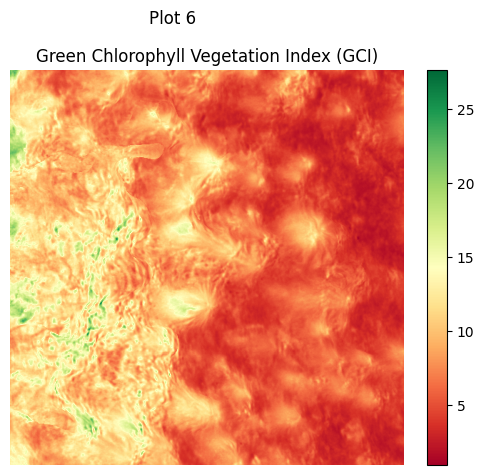

In [ ]:
i=6
plt.imshow(GCI_values[i],cmap='RdYlGn'),plt.axis('off'),plt.title('Green Chlorophyll Vegetation Index (GCI)'),
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Plot '+str(i))
plt.tight_layout()
plt.show()

In [46]:
from pathlib import Path
# the path of the directory which saves your .py file
src_dir = Path('/content/drive/MyDrive/Colab Notebooks/')

# add the path to system path
import sys
try:
  sys.path.index(str(src_dir))
except ValueError:
  sys.path.insert(0,str(src_dir))

# print system path
sys.path

['/content/drive/MyDrive/Colab Notebooks',
 '/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [55]:
# p1_np is of shape (4, 553, 552)
#The order is  G, R, RE, NIR for our stack
p1_np
p1_np_n = np.transpose(p1_np, (1, 2, 0))
#p1_np[3]
# Now, p1_np will be of shape (553, 552, 4) with the order of the bands preserved
p1_np_n.shape

(553, 552, 4)

In [ ]:
p1_np_n[:,:,3]

In [78]:
# Assuming p1_np is your array
np.isnan(p1_np)
np.sum(np.isnan(p1_np))


57

In [ ]:
np.isnan(p1_np)

In [ ]:
import cv2
from texture import fastglcm_wrapper

# Create an instance of the fastglcm_wrapper class
# Specify the parameters: levels, kernel_size, distance_offset, and angles
tex2 = fastglcm_wrapper(p1_np_n, levels=8, kernel_size=5, distance_offset=5, angles=[0, 45, 90, 135])


In [69]:
# Calculate various GLCM matrices
mean = tex2.calculate_glcm_mean()
variance = tex2.calculate_glcm_var()
contrast = tex2.calculate_glcm_contrast()
dissimilarity = tex2.calculate_glcm_dissimilarity()
homogeneity = tex2.calculate_glcm_homogenity()
asm = tex2.calculate_glcm_asm()
entropy = tex2.calculate_glcm_entropy()
maximum = tex2.calculate_glcm_max()
correlation = tex2.calculate_glcm_correlation()


/content/texture.py:173: RuntimeWarning: invalid value encountered in divide
  corr += (i*j*glcm[i,j] - mean_x*mean_y)/(std_x*std_y)


In [ ]:
mean[:,:,1].shape

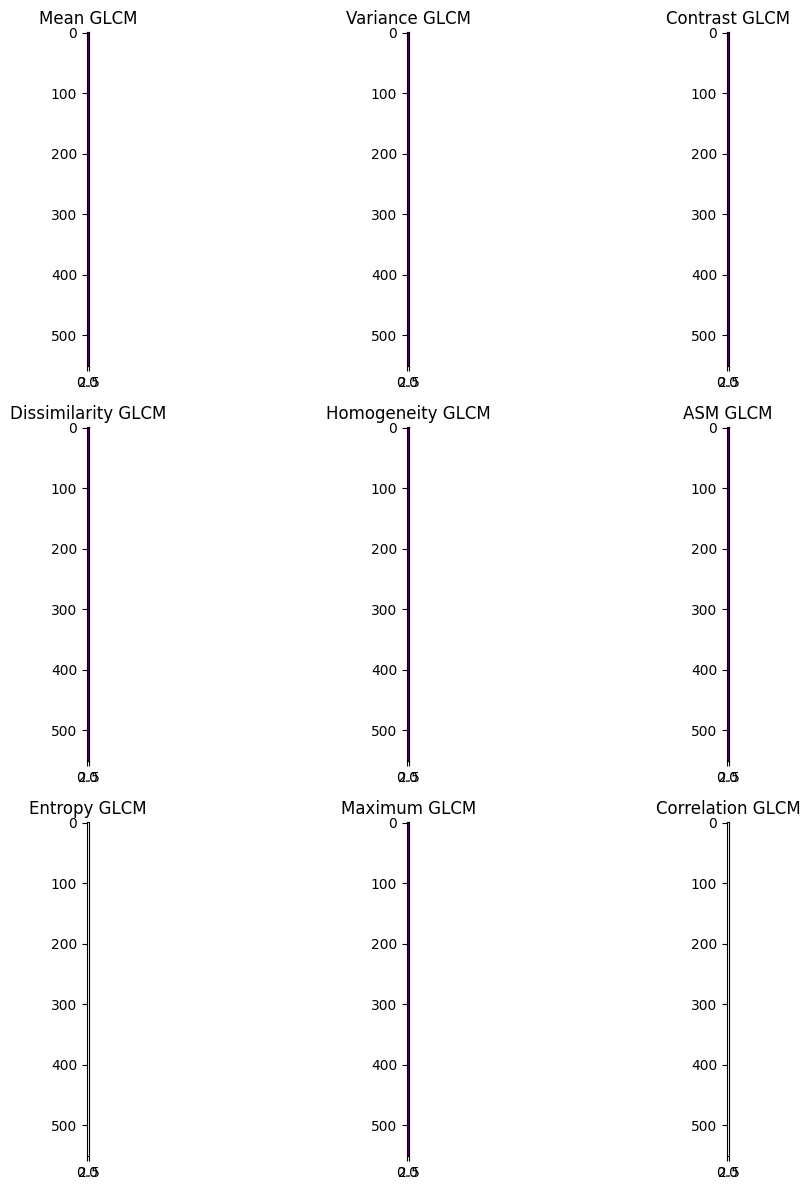

In [51]:
# Create subplots for all the GLCM matrices
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

i=0

# Plot GLCM matrices
axes[0, 0].imshow(mean[i], cmap='viridis')
axes[0, 0].set_title('Mean GLCM')
axes[0, 1].imshow(variance[i], cmap='viridis')
axes[0, 1].set_title('Variance GLCM')
axes[0, 2].imshow(contrast [i], cmap='viridis')
axes[0, 2].set_title('Contrast GLCM')

axes[1, 0].imshow(dissimilarity [i], cmap='viridis')
axes[1, 0].set_title('Dissimilarity GLCM')
axes[1, 1].imshow(homogeneity [i], cmap='viridis')
axes[1, 1].set_title('Homogeneity GLCM')
axes[1, 2].imshow(asm [i], cmap='viridis')
axes[1, 2].set_title('ASM GLCM')

axes[2, 0].imshow(entropy [i], cmap='viridis')
axes[2, 0].set_title('Entropy GLCM')
axes[2, 1].imshow(maximum [i], cmap='viridis')
axes[2, 1].set_title('Maximum GLCM')
axes[2, 2].imshow(correlation [i], cmap='viridis')
axes[2, 2].set_title('Correlation GLCM')

# Adjust the layout
plt.tight_layout()

# Display the subplots
plt.show()
